In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/Pubmed5k.xlsx


# Importing important modules

In [2]:
import nltk 
nltk.download('stopwords')
import re 
import numpy as np
import pandas as pd
from pprint import pprint

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#Spacy for lemmatization
import spacy 

#plotting tools 
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt 
%matplotlib inline

# Enable logging for gensim 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore" , category=DeprecationWarning)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


# **Prepare Stopwords**
We have already downloaded the stopwords. Let’s import them and make it available in stop_words

In [3]:
#NLTK stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
pip install openpyxl


     |████████████████████████████████| 242 kB 927 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [5]:
#importing Dataset
df = pd.read_excel('../input/dataset/Pubmed5k.xlsx')
df.head()

,ArticleID,Title,Abstract
0,34153941,Stable Coordination Variability in Overground ...,Coordination variability (CV) is commonly anal...
1,34153942,Weak Hip Strength Increases Dynamic Knee Valgu...,Clinical Scenario: Dynamic knee valgus (DKV) i...
2,34153964,Current and Future Projections of Amyotrophic ...,Various methodologies have been reported to as...
3,34153968,Disparities between Asian and Non-Asian Thromb...,As outcomes for acute ischemic stroke (AIS) va...
4,34153978,Maternal Factors Predicting Loss to Follow-Up ...,Because hearing loss in children can result in...


In [6]:
print(df.Title.unique())

['Stable Coordination Variability in Overground Walking and Running at Preferred and Fixed Speeds.'
 'Weak Hip Strength Increases Dynamic Knee Valgus in Single-Leg Tasks of Collegiate Female Athletes.'
 'Current and Future Projections of Amyotrophic Lateral Sclerosis in the United States Using Administrative Claims Data.'
 ...
 'Research on Adolescents Regarding the Indirect Effect of Depression, Anxiety, and Stress between TikTok Use Disorder and Memory Loss.'
 'Pre-Intervention Effects of a Community-Based Intervention Targeting Alcohol Use (LEF); The Role of Participatory Research and Publicity.'
 "Pharmacists' Role in Older Adults' Medication Regimen Complexity: A Systematic Review."]


**cleaning the data**

In [7]:
#convert to list 
data = df.Abstract.values.tolist()

#removing e-mails if exists
data = [re.sub('\S*@\S*\s' , '',sent) for sent in data]

#remove newline chars
data = [re.sub('\s+' , ' ' , sent) for sent in data]

#Remove distracting single quotes 
data = [re.sub("\'" , "" , sent) for sent in data]

pprint(data[:1])

['Coordination variability (CV) is commonly analyzed to understand dynamical '
 'qualities of human locomotion. The purpose of this study was to develop '
 'guidelines for the number of trials required to inform the calculation of a '
 'stable mean lower limb CV during overground locomotion. Three-dimensional '
 'lower limb kinematics were captured for 10 recreational runners performing '
 '20 trials each of preferred and fixed speed walking and running. Stance '
 'phase CV was calculated for 9 segment and joint couplings using a modified '
 'vector coding technique. The number of trials required to achieve a CV mean '
 'within 10% of 20 strides average was determined for each coupling and '
 'individual. The statistical outputs of mode (walking vs running) and speed '
 '(preferred vs fixed) were compared when informed by differing numbers of '
 'trials. A minimum of 11 trials were required for stable mean stance phase '
 'CV. With fewer than 11 trials, CV was underestimated and led to

# Tokenize words and clean-up text
**Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.**

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc=True))

data_words = list(sent_to_words(data))

print(data_words[:1])
        

[['coordination', 'variability', 'cv', 'is', 'commonly', 'analyzed', 'to', 'understand', 'dynamical', 'qualities', 'of', 'human', 'locomotion', 'the', 'purpose', 'of', 'this', 'study', 'was', 'to', 'develop', 'guidelines', 'for', 'the', 'number', 'of', 'trials', 'required', 'to', 'inform', 'the', 'calculation', 'of', 'stable', 'mean', 'lower', 'limb', 'cv', 'during', 'overground', 'locomotion', 'three', 'dimensional', 'lower', 'limb', 'kinematics', 'were', 'captured', 'for', 'recreational', 'runners', 'performing', 'trials', 'each', 'of', 'preferred', 'and', 'fixed', 'speed', 'walking', 'and', 'running', 'stance', 'phase', 'cv', 'was', 'calculated', 'for', 'segment', 'and', 'joint', 'couplings', 'using', 'modified', 'vector', 'coding', 'technique', 'the', 'number', 'of', 'trials', 'required', 'to', 'achieve', 'cv', 'mean', 'within', 'of', 'strides', 'average', 'was', 'determined', 'for', 'each', 'coupling', 'and', 'individual', 'the', 'statistical', 'outputs', 'of', 'mode', 'walking', 

# Creating Bigram and Trigram Models

In [9]:
#building the bigram and trigram models 
bigram = gensim.models.Phrases(data_words , min_count=5 , threshold=100)
trigram = gensim.models.Phrases(bigram[data_words] , threshold=100)

#faster way to get sentence clubbed as trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#see trigram example 
print(trigram_mod[bigram_mod[data_words[0]]])

['coordination', 'variability', 'cv', 'is', 'commonly', 'analyzed', 'to', 'understand', 'dynamical', 'qualities', 'of', 'human', 'locomotion', 'the', 'purpose', 'of', 'this', 'study', 'was', 'to', 'develop', 'guidelines', 'for', 'the', 'number', 'of', 'trials', 'required', 'to', 'inform', 'the', 'calculation', 'of', 'stable', 'mean', 'lower_limb', 'cv', 'during', 'overground', 'locomotion', 'three_dimensional', 'lower_limb', 'kinematics', 'were', 'captured', 'for', 'recreational', 'runners', 'performing', 'trials', 'each', 'of', 'preferred', 'and', 'fixed', 'speed', 'walking', 'and', 'running', 'stance', 'phase', 'cv', 'was', 'calculated', 'for', 'segment', 'and', 'joint', 'couplings', 'using', 'modified', 'vector', 'coding', 'technique', 'the', 'number', 'of', 'trials', 'required', 'to', 'achieve', 'cv', 'mean', 'within', 'of', 'strides', 'average', 'was', 'determined', 'for', 'each', 'coupling', 'and', 'individual', 'the', 'statistical', 'outputs', 'of', 'mode', 'walking', 'vs', 'run

# Remove Stopwords, Make Bigrams and Lemmatize
The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [10]:
#define functions for stopwords , bigrams , trigrams , lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts , allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out        

**Let's call the functions in order to perform the operations**

In [11]:
#remove stopwords
data_words_nostops = remove_stopwords(data_words)

#forming bi-grams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm' , disable=['parser', 'ner'])

#do lemmatizayion keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[['coordination', 'cv', 'commonly', 'analyze', 'understand', 'dynamical', 'quality', 'human', 'locomotion', 'purpose', 'study', 'develop', 'guideline', 'number', 'trial', 'require', 'inform', 'calculation', 'stable', 'mean', 'cv', 'overground', 'locomotion', 'kinematic', 'capture', 'recreational', 'runner', 'perform', 'trial', 'preferred', 'fix', 'speed', 'walk', 'run', 'stance', 'phase', 'cv', 'calculate', 'segment', 'joint', 'coupling', 'use', 'modify', 'vector', 'code', 'technique', 'number', 'trial', 'require', 'achieve', 'average', 'determine', 'couple', 'individual', 'statistical', 'output', 'mode', 'walk', 'run', 'speed', 'prefer', 'fix', 'compare', 'informed', 'differ', 'number', 'trial', 'minimum', 'trial', 'require', 'stable', 'mean', 'stance', 'phase', 'cv', 'few', 'trial', 'cv', 'underestimate', 'lead', 'oversight', 'significant', 'difference', 'mode', 'speed', 'future', 'overground', 'locomotion', 'cv', 'research', 'healthy', 'population', 'use', 'vector', 'code', 'approac

# Create the Dictionary and Corpus needed for Topic Modeling

In [12]:
#create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)

#ceate corpus
texts = data_lemmatized

#term document frequency 
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 6), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 3), (36, 2), (37, 2), (38, 2), (39, 1), (40, 1), (41, 4), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 3), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 3), (62, 2), (63, 2), (64, 1), (65, 1), (66, 2), (67, 1), (68, 8), (69, 1), (70, 1), (71, 2), (72, 2), (73, 2)]]


> **Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).**

> **For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.**

In [13]:
# readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('achieve', 1),
  ('analyze', 1),
  ('approach', 1),
  ('average', 1),
  ('aware', 1),
  ('calculate', 1),
  ('calculation', 1),
  ('capture', 1),
  ('code', 2),
  ('commonly', 1),
  ('compare', 1),
  ('consequence', 1),
  ('coordination', 1),
  ('couple', 1),
  ('coupling', 1),
  ('cv', 6),
  ('determine', 1),
  ('develop', 1),
  ('differ', 1),
  ('difference', 1),
  ('dynamical', 1),
  ('few', 1),
  ('finding', 1),
  ('fix', 2),
  ('future', 1),
  ('guideline', 1),
  ('healthy', 1),
  ('human', 1),
  ('individual', 1),
  ('inform', 1),
  ('informed', 1),
  ('insufficient', 1),
  ('joint', 1),
  ('kinematic', 1),
  ('lead', 1),
  ('locomotion', 3),
  ('mean', 2),
  ('minimum', 2),
  ('mode', 2),
  ('modify', 1),
  ('notable', 1),
  ('number', 4),
  ('output', 1),
  ('overall', 1),
  ('overground', 2),
  ('oversight', 1),
  ('perform', 1),
  ('phase', 2),
  ('population', 1),
  ('prefer', 1),
  ('preferred', 1),
  ('purpose', 1),
  ('quality', 1),
  ('recreational', 1),
  ('require',

# **Building The Topic Model**
***Let's try number of topics to be 10 then consider the optimal number of topics***

In [14]:
#Build LDA Model 
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# **View The Topics in LDA Model**
**the above model is built with 10 different topics where each topic is consists of variety of keywords each of these keyword has its certain weight that contributes to the topic**

***let's see in the next cell the importance score of the keyword for each topic***

In [15]:
#print the keyword in the 10 topics 
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.018*"water" + 0.014*"application" + 0.013*"method" + 0.011*"surface" + '
  '0.010*"process" + 0.009*"implant" + 0.009*"use" + 0.009*"product" + '
  '0.009*"chemical" + 0.008*"technique"'),
 (1,
  '0.037*"effect" + 0.030*"mortality" + 0.025*"increase" + 0.023*"induce" + '
  '0.020*"level" + 0.019*"stress" + 0.014*"high" + 0.013*"reduce" + '
  '0.011*"concentration" + 0.011*"rat"'),
 (2,
  '0.026*"age" + 0.021*"child" + 0.020*"exposure" + 0.018*"level" + '
  '0.017*"associate" + 0.016*"effect" + 0.016*"high" + 0.014*"study" + '
  '0.013*"association" + 0.013*"measure"'),
 (3,
  '0.031*"cell" + 0.019*"protein" + 0.015*"gene" + 0.011*"mechanism" + '
  '0.010*"expression" + 0.010*"human" + 0.009*"activity" + 0.009*"role" + '
  '0.008*"function" + 0.008*"target"'),
 (4,
  '0.035*"suicide" + 0.031*"infant" + 0.030*"video" + 0.021*"awareness" + '
  '0.021*"ct" + 0.017*"job" + 0.015*"suspect" + 0.013*"dentist" + '
  '0.012*"standard_deviation" + 0.011*"remission"'),
 (5,
  '0.017*"use

# **Compute Model Perplexity and Coherence Score**

***Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is.***

In [16]:
#Compute Perplexity
#a measure of how good the model is , more lower more better 
print('\nPerplexity: ' , lda_model.log_perplexity(corpus))

#Compute Coherence Score 
coherence_model_lda = CoherenceModel(model=lda_model , texts=data_lemmatized , dictionary=id2word , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ' , coherence_lda)


Perplexity:  -9.069331183698113

Coherence Score:  0.4519818239911716


# **Let's Now Visualize The Topics-Keywords**

***Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.***

In [17]:
#Visualize The Topics 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model , corpus , id2word)
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.215441  0.127906       1        1  28.786157
9     -0.213725  0.042489       2        1  18.738968
6     -0.146154 -0.114469       3        1  12.487816
7     -0.151324 -0.127173       4        1  12.020567
3     -0.019915  0.174070       5        1  10.274735
2     -0.041909 -0.206017       6        1   5.991377
0      0.087950  0.256130       7        1   5.781581
1      0.154718 -0.125851       8        1   3.922450
8      0.287528 -0.019299       9        1   1.524044
4      0.258272 -0.007785      10        1   0.472304, topic_info=                           Term         Freq        Total Category  logprob  \
172                     patient  5969.000000  5969.000000  Default  30.0000   
227                       group  2355.000000  2355.000000  Default  29.0000   
391                        cell  1816.000000  1816.000000  Default  28.0000   
1050                     effect  2233.000000  2233.000000  Default  27.0000   
159                      health  2334.000000  2334.000000  Default  26.0000   
...                         ...          ...          ...      ...      ...   
10340                        ep    14.258394    15.192575  Topic10  -5.2351   
4183                 odds_ratio    13.826802    14.761058  Topic10  -5.2658   
1891              insufficiency    13.689869    14.624354  Topic10  -5.2758   
7735   statistical_significance    13.475776    14.410461  Topic10  -5.2916   
771           determine_whether    13.347943    14.282541  Topic10  -5.3011   

       loglift  
172    30.0000  
227    29.0000  
391    28.0000  
1050   27.0000  
159    26.0000  
...        ...  
10340   5.2918  
4183    5.2899  
1891    5.2893  
7735    5.2882  
771     5.2876  

[544 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1845      2  0.996163    access
1932      1  0.980310  accuracy
1932      7  0.017987  accuracy
1043      7  0.330041      acid
1043      8  0.670559      acid
...     ...       ...       ...
192       2  0.093933      year
192       3  0.571886      year
192       4  0.098353      year
192       6  0.235385      year
2190      7  0.991865      zone

[850 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 10, 7, 8, 4, 3, 1, 2, 9, 5])

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.
We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text

# **How to find the optimal number of topics for LDA?**

***My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.***


In [18]:
def compute_coherence_values(dictionary , corpus , texts , limit , start = 2 , step = 1):
    """
    compute coherence score for various number of topics 
    
    parameters :
    ------------
    - dictionnary : Gensim Dictionary 
    - corpus : gensim corpus 
    - texts : list of input texts 
    - limit : maximum number of topics
    
    returns:
    --------
    - model list :List of LDA topic Models 
    - coherence_values : coherence values corresponding to the lda model with respective number of topics 
    """
    x = 1
    coherence_values = []
    model_list = []
    for num_topics in range(start , limit , step):
        model =  gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=x,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model , texts=texts , dictionary=dictionary , coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        x = x+1
        
    return model_list , coherence_values
            

In [19]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=1)

/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


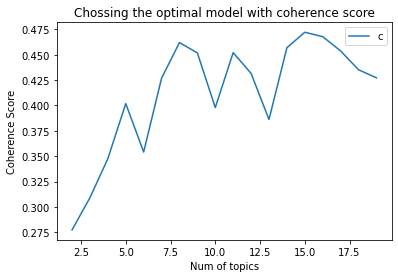

In [20]:
#show graph
x = range(2 , 20 , 1)
plt.plot(x , coherence_values)
plt.xlabel("Num of topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values") , loc='best')
plt.title("Chossing the optimal model with coherence score")
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2773
Num Topics = 3  has Coherence Value of 0.309
Num Topics = 4  has Coherence Value of 0.3475
Num Topics = 5  has Coherence Value of 0.4018
Num Topics = 6  has Coherence Value of 0.3541
Num Topics = 7  has Coherence Value of 0.4268
Num Topics = 8  has Coherence Value of 0.4619
Num Topics = 9  has Coherence Value of 0.4518
Num Topics = 10  has Coherence Value of 0.3979
Num Topics = 11  has Coherence Value of 0.452
Num Topics = 12  has Coherence Value of 0.4316
Num Topics = 13  has Coherence Value of 0.3861
Num Topics = 14  has Coherence Value of 0.4568
Num Topics = 15  has Coherence Value of 0.4721
Num Topics = 16  has Coherence Value of 0.4678
Num Topics = 17  has Coherence Value of 0.4537
Num Topics = 18  has Coherence Value of 0.4352
Num Topics = 19  has Coherence Value of 0.4272


# **As required**
**i'll continue using top 3 topics**

In [22]:
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.008*"cell" + 0.008*"use" + 0.006*"study" + 0.005*"result" + 0.005*"show" '
  '+ 0.005*"protein" + 0.005*"effect" + 0.005*"high" + 0.004*"specie" + '
  '0.004*"base"'),
 (1,
  '0.016*"study" + 0.010*"health" + 0.009*"use" + 0.006*"datum" + 0.005*"base" '
  '+ 0.005*"risk" + 0.005*"include" + 0.005*"care" + 0.004*"result" + '
  '0.004*"high"'),
 (2,
  '0.031*"patient" + 0.011*"treatment" + 0.010*"group" + 0.010*"study" + '
  '0.007*"clinical" + 0.007*"year" + 0.006*"high" + 0.006*"disease" + '
  '0.006*"risk" + 0.005*"case"')]


# Let's buld the model with the required number of topics
**and visulaize it**

In [23]:
#Build LDA Model 
lda_model_opt = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [24]:
pprint(lda_model_opt.print_topics())
doc_lda = lda_model_opt[corpus]

[(0,
  '0.008*"cell" + 0.008*"use" + 0.006*"study" + 0.005*"result" + 0.005*"show" '
  '+ 0.005*"protein" + 0.005*"effect" + 0.005*"high" + 0.004*"specie" + '
  '0.004*"base"'),
 (1,
  '0.016*"study" + 0.010*"health" + 0.009*"use" + 0.006*"datum" + 0.005*"base" '
  '+ 0.005*"risk" + 0.005*"include" + 0.005*"care" + 0.004*"result" + '
  '0.004*"high"'),
 (2,
  '0.031*"patient" + 0.011*"treatment" + 0.010*"group" + 0.010*"study" + '
  '0.007*"clinical" + 0.007*"year" + 0.006*"high" + 0.006*"disease" + '
  '0.006*"risk" + 0.005*"case"')]


# **Let's again Compute Model Perplexity and Coherence Score**
***Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is.***

In [25]:
#Compute Perplexity
#a measure of how good the model is , more lower more better 
print('\nPerplexity: ' , lda_model_opt.log_perplexity(corpus))

#Compute Coherence Score 
coherence_model_lda_opt = CoherenceModel(model=lda_model_opt , texts=data_lemmatized , dictionary=id2word , coherence='c_v')
coherence_lda_opt = coherence_model_lda_opt.get_coherence()
print('\nCoherence Score: ' , coherence_lda_opt)


Perplexity:  -8.28978851061961

Coherence Score:  0.34751347463623805


# **Let's Now Visualize The Topics-Keywords**

***Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.***

In [26]:
#Visualize The Topics 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_opt , corpus , id2word)
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.002861 -0.166034       1        1  38.541708
0     -0.174368  0.080957       2        1  35.553363
2      0.171507  0.085077       3        1  25.904929, topic_info=          Term         Freq        Total Category  logprob  loglift
172    patient  5281.000000  5281.000000  Default  30.0000  30.0000
159     health  2106.000000  2106.000000  Default  29.0000  29.0000
391       cell  1579.000000  1579.000000  Default  28.0000  28.0000
273  treatment  1959.000000  1959.000000  Default  27.0000  27.0000
227      group  2231.000000  2231.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
112      level   609.904369  1905.709404   Topic3  -5.4837   0.2114
105   increase   617.081121  2118.588839   Topic3  -5.4720   0.1172
156   evaluate   486.245929  1055.294556   Topic3  -5.7103   0.5759
71         use   663.420832  4221.911707   Topic3  -5.3996  -0.4999
366       show   468.331842  2093.931231   Topic3  -5.7478  -0.1469

[232 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1845      1  0.998025    access
689       1  0.281158  activity
689       2  0.625296  activity
689       3  0.093345  activity
194       1  0.082508     acute
...     ...       ...       ...
2362      1  0.998317     visit
1688      2  0.998481     water
1446      3  0.994281     wound
192       1  0.388624      year
192       3  0.611484      year

[333 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

# Let's Find out the dominant topic in each sentence
**One of the practical application of topic modeling is to determine what topic a given document is about.**

**To find that, we find the topic number that has the highest percentage contribution in that document.**

In [27]:
def format_topics_sentences(ldamodel = lda_model_opt , corpus = corpus, texts=data):
    #Init output
    sent_topics_df = pd.DataFrame()
    

    #Get The Main Topic in Each Document
    for i , row in enumerate(ldamodel[corpus]):
        row2 = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        #Get The Dominant Topic , Perc% Contibution and keywords for each document 
        for j , (topic_num , prop_topic) in enumerate(row2):
            if j == 0: # Dominant Topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word , prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num) , round(prop_topic,4) , topic_keywords]) , ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    #Add original text in the end of output 
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df , contents] , axis=1)
    return (sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_opt , corpus=corpus , texts=data)

#Formatting 
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5204,"study, health, use, datum, base, risk, include...",Coordination variability (CV) is commonly anal...
1,1,2.0,0.5205,"patient, treatment, group, study, clinical, ye...",Clinical Scenario: Dynamic knee valgus (DKV) i...
2,2,1.0,0.8874,"study, health, use, datum, base, risk, include...",Various methodologies have been reported to as...
3,3,2.0,0.7822,"patient, treatment, group, study, clinical, ye...",As outcomes for acute ischemic stroke (AIS) va...
4,4,1.0,0.9952,"study, health, use, datum, base, risk, include...",Because hearing loss in children can result in...
5,5,1.0,0.9413,"study, health, use, datum, base, risk, include...","Despite growing numbers in the USA, immigrant ..."
6,6,2.0,0.4672,"patient, treatment, group, study, clinical, ye...",Historically the treatment of lupus nephritis ...
7,7,1.0,0.5328,"study, health, use, datum, base, risk, include...",Progressive chronic kidney disease (CKD) in in...
8,8,2.0,0.6374,"patient, treatment, group, study, clinical, ye...",Immunoglobulin A nephropathy (IgAN) is the mos...
9,9,2.0,0.4221,"patient, treatment, group, study, clinical, ye...","In kidney transplantation, precision medicine ..."


# **Conclusion**

> **First things first i want to thank everyone that give me the honor to proceed to this step**

> **Second I really hope this simple NoteBook Meet your Expectations**

> **And I really happy to say i'm really honord by this chance , whatever the result you see i accept it happily**

# **About the next steps to improve The Model**
> **We Could Expand The Number Of Topics To get More Better Coherence Score**

> **Expand The DataSet And Get More Organised Documents For Better Results**

> ***Finally I want To Say SomeThing .. Maybe This Work Isn't Ideal For Your Needs , But to Be Honest This is The First Time For Me To work With This Algorithm(LDA) , Shame On Me Ofcourse , But I really Tried My Best To Learn With The Fly To Get The Best Results as much as i can , I really happy to deal with new algorithm and of course i'll add this valuable Task To my Portfolio***